In [ ]:
import argparse
import random
import os
import cv2
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from mlxtend.plotting import plot_confusion_matrix
from google.colab.patches import cv2_imshow
from tensorflow.keras.utils import to_categorical
from imutils import paths
from keras.utils.data_utils import random 
from keras.models import Sequential
from tensorflow.keras.layers import AveragePooling2D,Dropout,Flatten,Dense,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint  

Mount and Import Dataset From Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
training_dir = root_dir + "/DeepLearning_Hw4/CaltechTinySplit/train/"
testing_dir = root_dir + "/DeepLearning_Hw4/CaltechTinySplit/test/"

Mounted at /content/gdrive


Convert Image Path to List

In [ ]:
train_path = paths.list_images(training_dir)
train_path = sorted(train_path)

test_path = paths.list_images(testing_dir)
test_path = sorted(test_path)

Add Image Path to List

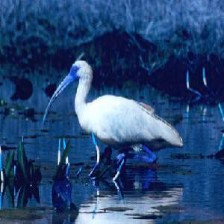

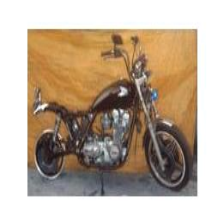

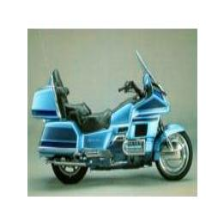

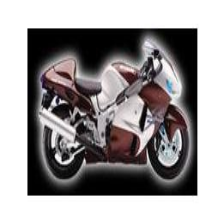

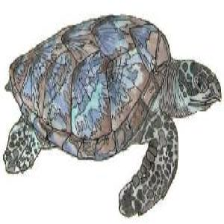

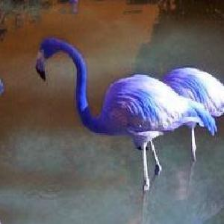

In [ ]:
data = []
labels = []
for trainPath in train_path:
    label = trainPath.split(os.path.sep)[-2]
    image = cv2.imread(trainPath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #BGR to RGB
    image = cv2.resize(image, (224, 224)) #resize the image to 224 by 224.
    data.append(image)
    labels.append(label)
#We print 6 random images
for i in range(0,6):
  rand_num=random.randint(0,len(data))
  img=data[rand_num]
  cv2_imshow(img)


In [ ]:
#We are converting our data to array.
data =  np.array(data) /255.0
#We are converting our train labels to array.
labels = np.array(labels)
lb = LabelBinarizer()
labels = lb.fit_transform(labels)


Learning Rate,Epochs,Batch Size

Initialize Learning Rate, Epochs, Batch Size, and Data Augmentation

In [ ]:
learning_rate = 1e-3
Epochs = 50
Batch_Size = 16
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

train_datagen = ImageDataGenerator(rotation_range = 15, fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(testing_dir,
    target_size = (224, 224),
    color_mode = 'rgb',
    batch_size = Batch_Size,seed=42,
    class_mode="categorical",
    shuffle = False)

Found 174 images belonging to 9 classes.


Mish Activation

In [ ]:
from tensorflow.keras.utils import get_custom_objects 
def mish(x,beta=1):
  return x*tf.math.tanh(tf.math.softplus(x))
get_custom_objects().update({'mish':mish})

Create CNN Model

In [ ]:
from keras.layers.core import Activation
from keras.layers import Conv2D,MaxPooling2D
from keras.models import Sequential
from keras.layers import BatchNormalization
import keras
num_classes=9 #We have 9 classes.
img_width,img_height, channels = 224,224,3 #input shape
inputShape = (img_width,img_height,channels)
#Create the model
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="mish", 
                        input_shape=inputShape,padding="same")) #padding = 1
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="mish", 
                        padding="same"))

model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.30))

model.add(Conv2D(filters=128, kernel_size=(3, 3), 
                        strides=(4, 4), activation="mish", 
                        input_shape=(224, 224, 3)))

model.add(Conv2D(filters=64, kernel_size=(2, 2), 
                        strides=(1, 1), activation="mish", 
                        padding="same"))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten(name="flatten"))
model.add(Dense(128, activation="mish"))
model.add(Dense(64, activation="mish"))
model.add(Dense(num_classes, activation="softmax"))

Optimizer = Adam(lr=learning_rate, decay=learning_rate / Epochs)
model.compile(loss="binary_crossentropy", optimizer=Optimizer, metrics=["accuracy"])

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      18464     
                                                                 
 average_pooling2d (AverageP  (None, 112, 112, 32)     0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       36992     
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        32832     
                                                        

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training Model CNN

In [ ]:
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=1000,
    decay_rate=0.9)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.01)
checkpoint_filepath="/content/gdrive/My Drive/DeepLearning_Hw4/modeldeep.h5" #save model
CheckPointer = ModelCheckpoint(filepath=checkpoint_filepath,period=1,  
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="max")
#We are fitting our model
history = model.fit(
    train_datagen.flow(trainX, trainY, batch_size=Batch_Size),
    steps_per_epoch=len(trainX) // Batch_Size,
    validation_data=(testX, testY),
    validation_steps=len(testX) // Batch_Size,
    epochs=Epochs,callbacks=[CheckPointer, lr_schedule,early_stop])

Epoch 1/50
67/67 [==============================] - ETA: 0s - loss: 0.2094 - accuracy: 0.6708
Epoch 1: val_accuracy improved from -inf to 0.77778, saving model to /content/gdrive/My Drive/DeepLearning_Hw4/modeldeep.h5
67/67 [==============================] - 20s 202ms/step - loss: 0.2094 - accuracy: 0.6708 - val_loss: 0.1414 - val_accuracy: 0.7778 - lr: 0.0010
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 0.1372 - accuracy: 0.7792
Epoch 2: val_accuracy did not improve from 0.77778
67/67 [==============================] - 12s 183ms/step - loss: 0.1372 - accuracy: 0.7792 - val_loss: 0.1484 - val_accuracy: 0.7259 - lr: 9.9989e-04
Epoch 3/50
67/67 [==============================] - ETA: 0s - loss: 0.1106 - accuracy: 0.8170
Epoch 3: val_accuracy improved from 0.77778 to 0.80741, saving model to /content/gdrive/My Drive/DeepLearning_Hw4/modeldeep.h5
67/67 [==============================] - 13s 188ms/step - loss: 0.1106 - accuracy: 0.8170 - val_loss: 0.1076 - val_accurac

Visualization model training

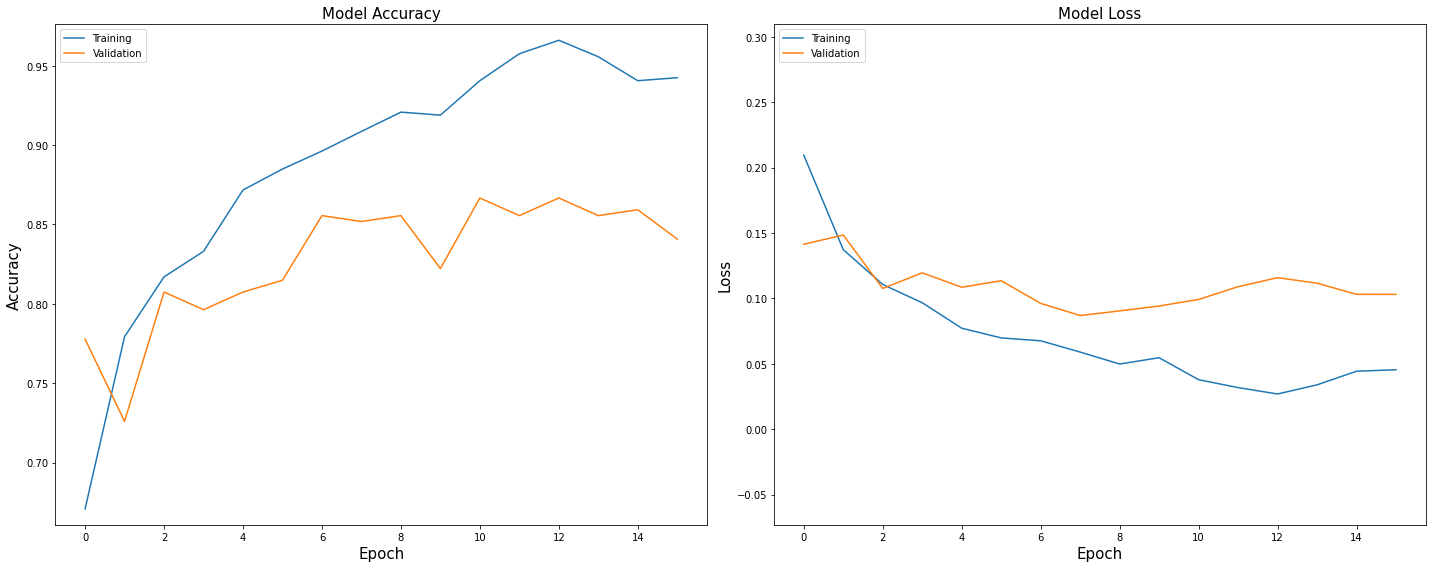

In [ ]:
xlabel = 'Epoch'
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]
plt.figure(figsize=(20, 8))

# Plot training & validation Accuracy values
y1 = history.history['accuracy']
y2 = history.history['val_accuracy']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]

plt.subplot(121)
plt.plot(y1)
plt.plot(y2)
plt.title('Model Accuracy', fontsize=15)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.tight_layout()  
                         
# Plot training & validation loss values
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
plt.subplot(122)
plt.plot(y1)
plt.plot(y2)
plt.title('Model Loss', fontsize=15)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')

plt.tight_layout()                  
plt.show()

Evaluate Model

In [ ]:
print("results evaluate model")
result  = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

results evaluate model
11/11 [==============================] - 1s 94ms/step - loss: 0.1077 - accuracy: 0.8448
Loss     : 0.11  
Accuracy : 84.48%


Confusion Matrix

<ipython-input-12-cb5fd7b98ae0>:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator,  steps=len(test_generator),verbose=2)


11/11 - 1s - 819ms/epoch - 74ms/step
Result Confusion Matrix
------------------------------------------------------------------------------------------
Accuracy:  87.93103448275862 %
Precision:  82.099451303155 %
Recall:  69.91426611796983 %
f1:  71.38758594235347 %


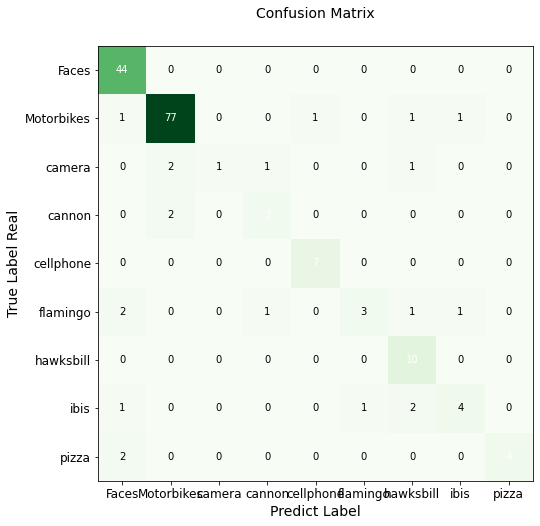

Sensitivity: 100.00%
Specificity: 98.72%


              precision    recall  f1-score   support

       Faces       0.88      1.00      0.94        44
  Motorbikes       0.95      0.95      0.95        81
      camera       1.00      0.20      0.33         5
      cannon       0.60      0.60      0.60         5
   cellphone       0.88      1.00      0.93         7
    flamingo       0.75      0.38      0.50         8
   hawksbill       0.67      1.00      0.80        10
        ibis       0.67      0.50      0.57         8
       pizza       1.00      0.67      0.80         6

    accuracy                           0.88       174
   macro avg       0.82      0.70      0.71       174
weighted avg       0.88      0.88      0.87       174



In [ ]:
# evaluate the model
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
import numpy as np 
y_true = test_generator.classes

model.load_weights("/content/gdrive/My Drive/DeepLearning_Hw4/modeldeep.h5") #load model
predictions = model.predict_generator(test_generator,  steps=len(test_generator),verbose=2)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)


def scores(y_true,y_pred):
  accuracy = accuracy_score(y_true,y_pred)
  precision = precision_score(y_true,y_pred,average='macro')
  recall = recall_score(y_true,y_pred,average='macro')
  f1 = f1_score(y_true,y_pred,average='macro')
  confusionmatrix = confusion_matrix(y_true, y_pred)
  print("="*90)
  print("Result Confusion Matrix")
  print("-"*90)
  print("Accuracy: ", accuracy*100, "%")
  print("Precision: ", precision*100, "%")
  print("Recall: ", recall*100, "%")
  print("f1: ", f1*100, "%")
  print("="*90)
  fig, ax = plot_confusion_matrix(conf_mat=confusionmatrix ,  figsize=(10,8), hide_ticks=True,cmap=plt.cm.Greens)
  plt.xticks(range(len(lb.classes_)), lb.classes_, fontsize=12)
  plt.yticks(range(len(lb.classes_)), lb.classes_, fontsize=12)
  plt.title("Confusion Matrix", fontsize=14)
  plt.ylabel('True Label Real',fontsize=14)
  plt.xlabel('Predict Label',fontsize=14)
  plt.show()

  cls_report_print = classification_report(y_true, y_pred, target_names=lb.classes_)
  cls_report = classification_report(y_true, y_pred, target_names=lb.classes_, output_dict=True)
  total1=sum(sum(confusionmatrix))

  ##### From confusion matrix calculate accuracy
  print("="*90)
  sensitivity1 = confusionmatrix[0,0]/(confusionmatrix[0,0]+confusionmatrix[0,1])
  print("%s%.2f%s"% ("Sensitivity: ", sensitivity1*100, "%"))
  specificity1 = confusionmatrix[1,1]/(confusionmatrix[1,0]+confusionmatrix[1,1])
  print("%s%.2f%s"% ("Specificity: ", specificity1*100, "%"))

  print("\n")
  print("="*90)
  print("="*90)
  print(cls_report_print)
  print("="*90)

scores(y_true,predicted_classes)